In [264]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", palette="Paired")

%load_ext autoreload
%autoreload 2

import numpy as np
import gym
import sys
import os
if "../" not in sys.path:
    sys.path.insert(0, "../")

    
from logger import *
setup_logging(default_level=logging.INFO)

from sklearn import manifold, datasets
from sklearn.utils import check_random_state


from algo.lstd import LSTDQ, LSTDMu, LSPI
from algo.policy import RandomPolicy2, LinearQ2
from algo.fa import LinearQ3
from algo.apprenticeship_learning import ApprenticeshipLearning as AL
from env.simulator import * 
from util.plotting import *
from util.basis import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
env_id = "MountainCar-v0"
env = gym.envs.make(env_id)
state_dim = env.observation_space.shape[0]
# discrete action
action_dim = 1
n_action = env.action_space.n
action_list = range(env.action_space.n)
sim = Simulator(env, state_dim=state_dim, action_dim=action_dim)
# default
s_init = [-0.5, 0]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [266]:
# hack to give us control over the initial state
import types

def new_timelimit_reset(self, s_init=None):
    import time
    self._episode_started_at = time.time()
    self._elapsed_steps = 0
    return self.env.reset(s_init)

def new_reset(self, s_init):
    if s_init is None:
        s_init = [np.random.uniform(-0.6, -0.4), 0]
    self.state = np.array(s_init)
    return np.array(self.state)
env.reset = types.MethodType(new_timelimit_reset, env)
env.env.reset = types.MethodType(new_reset, env.env)
print(env.reset([-.3, 0.3]))

[-0.3  0.3]


## obtain expert policy $\pi_{exp}$
- with linearly paramatized Q
- with radial basis function

In [271]:
include_action = False
# if this is True, then the state space becomes very large
# therefore, a more denser, higher number of phi is needed

p_linear = 2 * n_action
q_linear = 2 * n_action
phi_linear = LinearKernel2(p_linear, n_action, include_action).transform
psi_linear = phi_linear

n_component_list = [10, 10]
gamma_list = [0.5, 30.0]
#gamma_list = [0.5, 5.0, 30.0]
p_rbf =  int(np.sum(n_component_list)) * n_action
q_rbf = int(np.sum(n_component_list)) * n_action

# technically the truly-batch mode should use D to fit rbf kenel
states = np.array([env.observation_space.sample() for x in range(10000)])
phi_rbf = RBFKernel2(states, n_action, p_rbf, n_component_list, gamma_list, include_action).transform
psi_rbf = phi_rbf

precision = 1e-2
eps = 0.01
gamma = 0.99

n_component = 10
add_bias = True
p_gaus = (n_component**2 + int(add_bias)) * n_action 
phi_gaus = GaussianKernel(states, n_action, p_gaus, n_component, include_action, add_bias).transform


/usr/local/lib64/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 169 @ Episode 150/150 (-84.0))

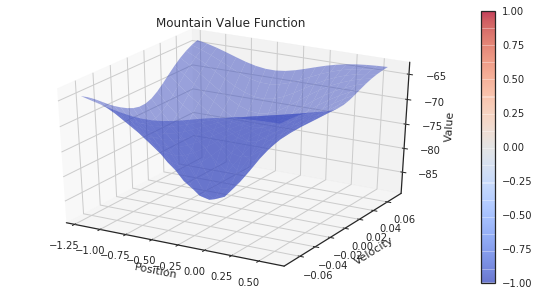

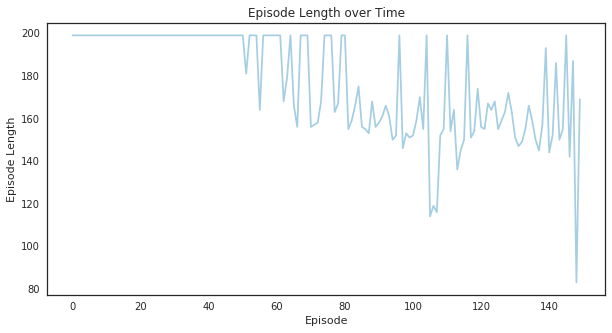

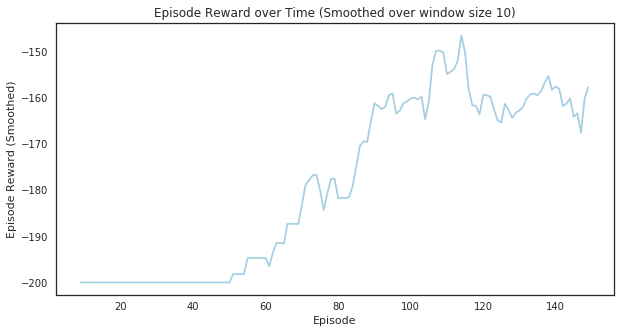

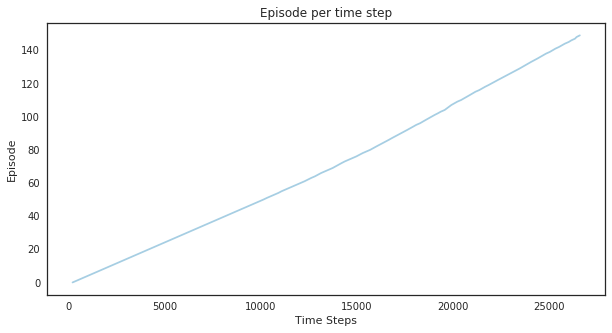

(<matplotlib.figure.Figure at 0x7fa43de19860>,
 <matplotlib.figure.Figure at 0x7fa43dff2550>)

In [272]:
phi = phi_gaus
p = p_gaus

mdp_solver = LinearQ3(env=env,
                      phi=phi,
                      p=p,
                      action_list=action_list,
                      n_episode=150,
                      epsilon=0.0,
                      epsilon_decay=1.00,
                      gamma=gamma)

pi_expert, stats = mdp_solver.solve(reward_fn=None)
plotting.plot_cost_to_go_mountain_car(env, pi_expert._estimator)
plotting.plot_episode_stats(stats, smoothing_window=10)

## generate trajectories under expert policy (=D)

In [273]:
class NearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.1, 0.1)
        c = 0
        return 0 if v <= c else 2

class OppositeNearExpertPolicy():
    """
    hard-coded near-optimal expert policy
    for mountaincar-v0
    """
    def choose_action(self, s):
        pos, v = s
        c = np.random.uniform(-0.1, 0.1)
        return 0 if v > c else 2
pi_near = NearExpertPolicy()
pi_near_ops = OppositeNearExpertPolicy()
pi_random = RandomPolicy2(action_list)


In [297]:
# mixed training set
pi_list = [pi_random, pi_near_ops, pi_near, pi_expert]
mix_ratio = [0.5, 0.1, 0.1, 0.3]
sample_size = 3000

D = sim.simulate_mixed(env, pi_list, sample_size, mix_ratio)
D_mat = Simulator.to_matrix(D)

# pure expert

D_pure = sim.simulate(pi_expert, 1, 100)
D_pure_mat = Simulator.to_matrix(D)


Step 143 @ Episode 100/100 (-84.0))0)

## mixed training set & pure training dataset

In [ ]:
plot_trajectory_mountain_car(D)

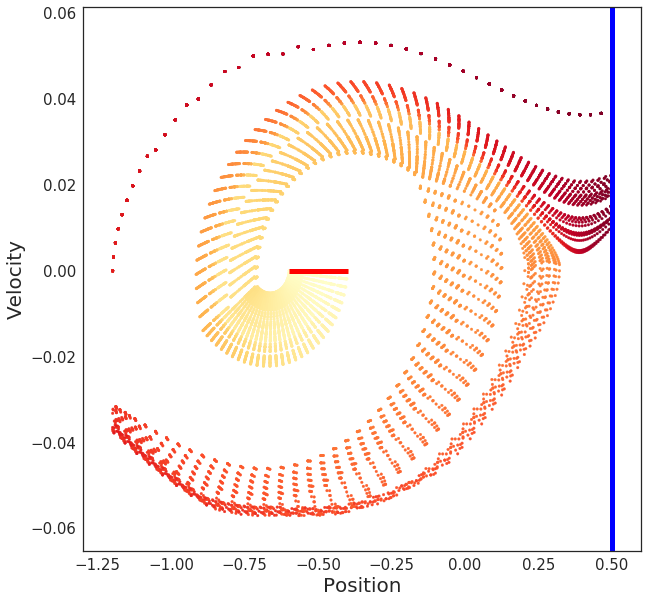

In [276]:
plot_trajectory_mountain_car(D_pure)

(array([  1621.,   1831.,   4986.,  16437.,  13823.,   1853.,   2123.,
          2614.,   1741.,   1265.]),
 array([-1.2       , -1.03002883, -0.86005765, -0.69008648, -0.5201153 ,
        -0.35014413, -0.18017295, -0.01020178,  0.1597694 ,  0.32974057,
         0.49971175]),
 <a list of 10 Patch objects>)

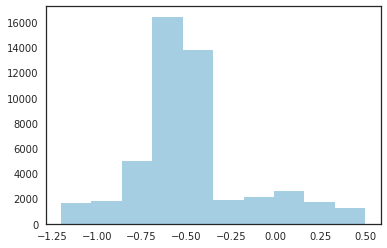

In [257]:
s = np.vstack(D_mat[:, 0])
a = np.vstack(D_mat[:, 1])
r = np.vstack([reward_fn2(s,a) for s, a in zip(s, a)])
plt.hist(s[:, 0])

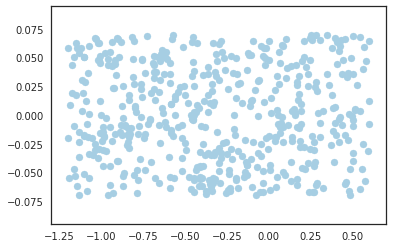

In [258]:
samples=np.array([env.observation_space.sample() for _ in range(500)])
plt.scatter(samples[:, 0], samples[:, 1])

## study the behavior of $\gamma$
- small gamma (high variance) gives sparse coding but requires less centers (components)
- large gamma (low variance) gives dense coding but requires more centers (components)
- components: need enough (also need to consider gamma) numbers to cover the state space 

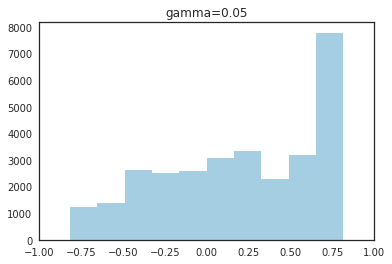

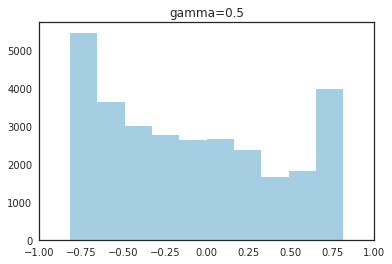

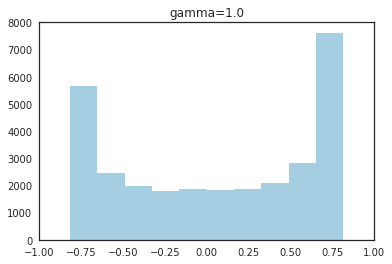

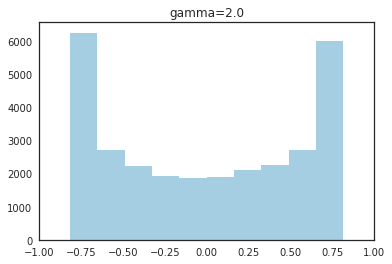

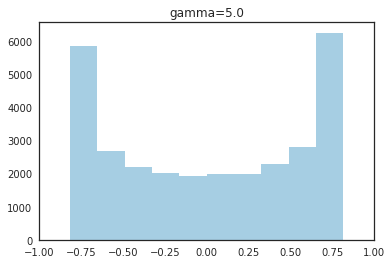

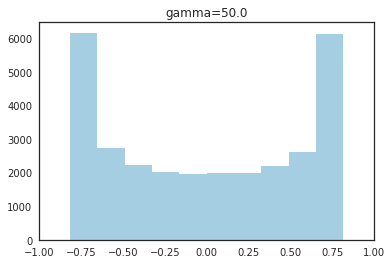

In [261]:
def plot_gamma(gammas):
    for g in gammas:
        components = [3]
        gamma_list = [g]
        p_rbf =  int(np.sum(components)) * n_action
        q_rbf = int(np.sum(components)) * n_action
        #states = np.array([env.observation_space.sample() for x in range(1000)])
        s = np.vstack(D_mat[:, 0])
        samples = s
        phi_rbf = RBFKernel2(samples, n_action, p_rbf, components, gamma_list, include_action).transform
        phis = np.array([phi_rbf(s, 1).flatten() for s in states])

        plt.figure()
        plt.title("gamma={}".format(g))
        plt.xlim(-1.0, 1.0)
        plt.hist(phis[phis != 0])
gammas = [0.05, 0.5, 1.0, 2.0, 5.0, 50.0]
plot_gamma(gammas)

### cross validate for basis features
- to avoid underdtermined system
- the smaller n_component is, the smaller the number of gammas, the more likely the linear system is stable
- however, a full rank system may not give a good policy
- if n_component is small like 5, a very high gamma is necessary to cover sufficiently large state space
- if phi(s), small n_component is enough, if phi(s,a) larger n_component and more powerful stuffi is needed
- gamma should be larger (larger variance)
- n_component should be small (but not rich)
- gamma clearly heavily influences basis features and tehrefore the rank of A
- reward function influences the norm scale
- mix small and large gammas (why?)
- perhaps n_component for each gamma should be different?

In [ ]:
include_action = False
# if this is True, then the state space becomes very large
# therefore, a more denser, higher number of phi is needed

p_linear = 2 * n_action
q_linear = 2 * n_action
phi_linear = LinearKernel2(p_linear, n_action, include_action).transform
psi_linear = phi_linear

components = [10, 10]
gamma_list = [0.1, 50.0]
#gamma_list = [1.0, 30.0, 50.0]
#gamma_list = [0.5, 5.0, 30.0]
p_rbf =  int(np.sum(components)) * n_action
q_rbf = int(np.sum(components)) * n_action

states = np.array([env.observation_space.sample() for x in range(10000)])

# technically the truly-batch mode should use D to fit rbf kenel
s = np.vstack(D_mat[:, 0])
samples = s


phi_rbf = RBFKernel2(samples, n_action, p_rbf, components, gamma_list, include_action).transform
psi_rbf = phi_rbf

precision = 1e-2
eps = 0.01
gamma = 0.99

n_component = 6
add_bias = True
p_gaus = (n_component**2 + int(add_bias)) * n_action 
phi_gaus = GaussianKernel(samples, n_action, p_gaus, n_component, include_action, add_bias).transform

## Solve MountainCar-v0 with LSPI


In [ ]:
def solve_mountain_car(p, phi, gamma, precision, eps, D, reward_fn=None, max_iter=10):  
    W_0 = np.random.rand(p)
    lspi = LSPI(D=D,
                action_list=action_list,
                p=p,
                phi=phi,
                gamma=gamma,
                precision=precision,
                eps=eps,
                W_0=W_0,
                reward_fn=reward_fn,
                max_iter=max_iter)

    W, w_list = lspi.solve()
    return W, w_list
print("batch data size {}".format(np.array(D_mat).shape))
eps = 0.00

# mixed

#W_linear = solve_mountain_car(p_linear, phi_linear, gamma, precision, eps, D_mat, None, 10)
#w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 15)
#w_rbf, w_list = solve_mountain_car(p_gaus, phi_gaus, gamma, precision, eps, D_mat, None, 15)

# pure

#W_linear = solve_mountain_car(p_linear, phi_linear, gamma, precision, eps, D_mat, None, 10)
#w_rbf, w_list = solve_mountain_car(p_rbf, phi_rbf, gamma, precision, eps, D_mat, None, 15)
w_rbf, w_list = solve_mountain_car(p_gaus, phi_gaus, gamma, precision, eps, D_pure_mat, None, 15)

INFO:root:fitting D of the dimension:
(517914, 5)


batch data size (517914, 5)


1.8889558087032983e+18
INFO:root:lspi norm 12888078.641739003


## check the policies returned by LSPI

In [ ]:
phi = phi_gaus

for w in w_list: 
    pi_star = LinearQ2(action_list=action_list, phi=phi, W=w)
    #pi_star = LinearQ2(action_list=action_list, phi=phi_linear, W=W_linear)
    D_star, stats = sim.simulate(pi=pi_star, n_trial=1, n_episode=30, return_stats=True)
    plot_trajectory_mountain_car(D_star)    
    plot_cost_to_go_mountain_car(env, pi_star)
    #plot_episode_stats(stats, smoothing_window=5)

# study the sensitivity of LSPI to reward functions
- the default reward function is -1 always
- generally, lspi norm varies with reward function choice (why?)

In [237]:
# preprocess reward if needed
def reward_fn1(s, a):
    pos, v = s
    return 1 if pos > 0.45 else 0

def reward_fn2(s, a):
    pos, v = s
    return 10*(pos + 0.6)**2

def reward_fn3(s, a):
    pos, v = s
    if pos < -0.75:
        return 0
    elif pos < 0.25:
        return -1
    else:
        return 100


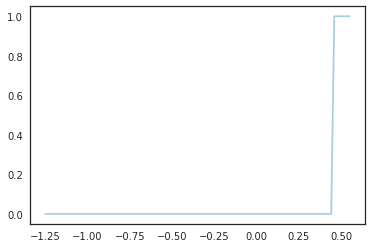

In [238]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn1([x, 0], 0) for x in xx]
plt.plot(xx, r)

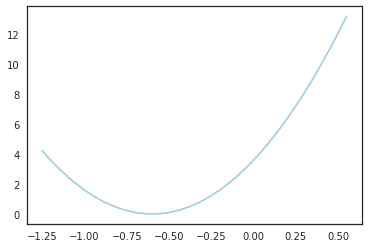

In [239]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn2([x, 0], 0) for x in xx]
plt.plot(xx, r)

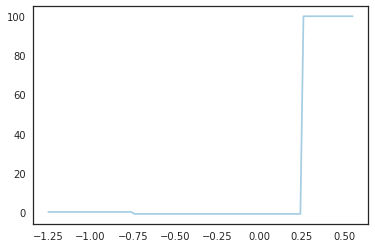

In [240]:
xx = np.linspace(-1.25, 0.55, 100)
r = [reward_fn3([x, 0], 0) for x in xx]
plt.plot(xx, r)

## apply apprenticeship learning

In [241]:
## value margin

In [242]:
results = np.load("data/res_1522884923.4368284")
pi_irl_list = results['solutions']
D_irl = sim.simulate(pi_irl_list[0], n_trial=1, n_episode=50)

FileNotFoundError: [Errno 2] No such file or directory: 'data/res_1522884923.4368284'

In [ ]:
pi_irl_list[0]._phi([0.5, 0.2], 1)

In [ ]:
sns.set(style='white', palette='Blues')

fig = plt.figure(figsize=(10, 10))
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)

ax = plt.gca()
lines = [[(-0.4, 0.0), (-0.6, 0.0)]]
c = np.array([(1, 0, 0, 1)])
lc = mc.LineCollection(lines, colors='red', linewidths=5)
ax.add_collection(lc)
for episode in D_irl:
    states = []
    for (s, a, r, s_next, done) in episode:
        states.append(s)
    states = np.array(states)
    sc = ax.scatter(states[:,0], states[:,1], c=range(len(states[:,0])), cmap=plt.get_cmap("YlOrRd"), s=7.0)
#ax.axis([-1.2,0.6,-0.07,0.07])
ax.axvline(0.5, c='blue', linewidth=5)
ax.set_xlabel('Position', fontsize=20.0)
ax.set_ylabel('Velocity', fontsize=20.0)
#plt.colorbar(sc)
plt.show()


In [ ]:
from matplotlib import collections  as mc

sns.set(style='white', palette='Blues')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plt.xticks(fontsize=15.0)
plt.yticks(fontsize=15.0)

titles = ["Near-expert policy trajectories", "IRL poilcy trajectories"]
for title, ax, trajs_irl in zip(titles, axes, [trajs_expert_near, D_irl]):
    lines = [[(-0.4, 0.0), (-0.6, 0.0)]]
    c = np.array([(1, 0, 0, 1)])
    lc = mc.LineCollection(lines, colors='red', linewidths=5)
    ax.set_title(title, fontsize=20.0)

    ax.add_collection(lc)
    for episode in trajs_irl:
        states = []
        try:
            for s, a, r, s_next, done in episode:
                states.append(s)
        except:
            import pdb;pdb.set_trace()
        states = np.array(states)
        sc = ax.scatter(states[:,0], states[:,1], c=range(len(states[:,0])), cmap=plt.get_cmap("YlOrRd"), s=7.0)
    #ax.axis([-1.2,0.6,-0.07,0.07])
    ax.axvline(0.5, c='blue', linewidth=5)
    ax.set_xlabel('Position', fontsize=20.0)
    ax.set_ylabel('Velocity', fontsize=20.0)
    #plt.colorbar(sc)
plt.show()


In [ ]:
margin_v_collection = results['margin_v']
margin_mu_collection = results['margin_mu']
mu_collection = results['mu']

In [ ]:
ax = plt.gca()
print('e')
for mu_list in mu_collection:
    mu_list = np.array(mu_list)
    #ax.scatter(mu_list[:, 0], mu_list[:, 1], c = range(len(mu_list[:,1])), cmap=plt.get_cmap("YlOrRd"))

mu_exp_list = np.array(estimate_mu_mc(env, pi_expert_near, phi_linear, gamma, 1000))
mu_exp = mu_exp_list.mean(axis=0)
ax.scatter(mu_exp[0], mu_exp[1], c='b')

In [ ]:
print(mu_exp_list.mean(axis=0).shape)
print(mu_exp_list.mean(axis=1)[1])

In [ ]:
from scipy.stats import sem
D_v = np.array(margin_v_collection)
mu_hat = np.mean(D_v, axis=0)
s = sem(D_v, axis=0)
ax = plt.gca()
ax.errorbar(np.arange(D_v.shape[1]), mu_hat, yerr=s, fmt="--o", c='g')
ax.set_title('value margin')
plt.show()

In [ ]:
from scipy.stats import sem
D_mu = np.array(margin_mu_collection)
mu_hat = np.mean(D_mu, axis=0)
s = sem(D_mu, axis=0)
ax = plt.gca()
ax.set_title('feature expectation margin')
ax.errorbar(np.arange(D_mu.shape[1]), mu_hat, yerr=s, fmt="--o", c='b')
plt.show()

In [ ]:
import pickle
from time import time
with open("data/res_{}.pkl".format(time()), "wb") as f:
    pickle.dump({'name': 'james'}, f, protocol=pickle.HIGHEST_PROTOCOL)


##
- number of samples
- fitted reward vs. true reward
- violation of actions
- trajectory matching
- margin

